<a href="https://colab.research.google.com/github/douglasmmachado/ImageProcessingProject/blob/master/Final_Project_DUPRE_LAURENCIN_MACHADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image processing project ASI 2A**


First, we will :


1.   Load the libraries we'll be using
2.   Load the image to reconstruct
3.  Load the patch database
4. Extract all possible pieces (32x32 patches) from the image to reconstruct

In [1]:
# Imports and configurations
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image
import requests
from io import BytesIO

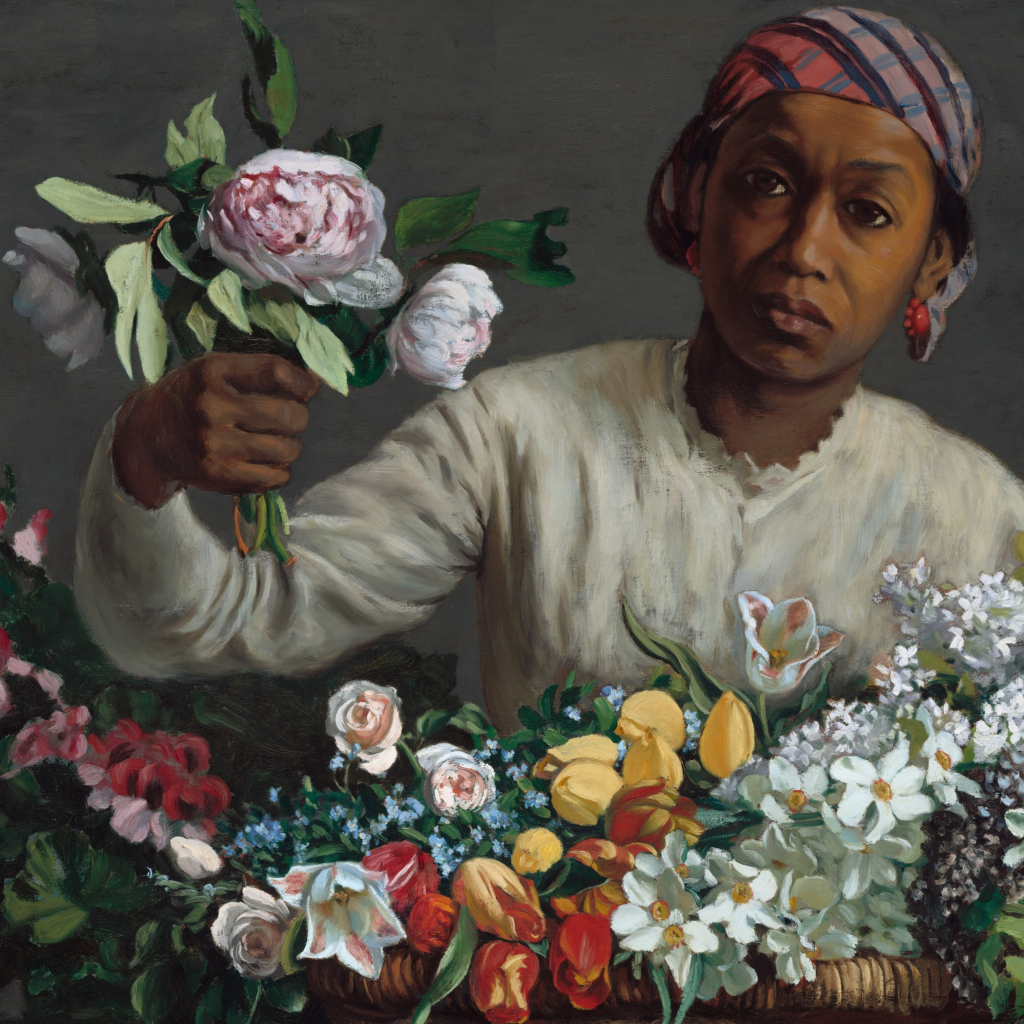

In [17]:
#First step loading image from repo
image_url = "https://raw.githubusercontent.com/douglasmmachado/ImageProcessingProject/master/images/img_1.png"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')
img_array = np.array(img) 
img.show()



In [16]:
def extract_patches(image, patch_size):
    patches = []
    height, width, _ = image.shape
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size, :]
            patches.append(patch)
    return patches

# Extract patches from the image to reconstruct:
patch_size = 32  # Size of the patches
query_patches = extract_patches(img_array, patch_size)


Construction of the metric
Personnal thoughts :
We could explore using histogram comparison or intercorrelation to compare the patches.

In [14]:
def calculate_similarity(image1, image2, metric):
    """
    Calculate the similarity between two images using the chosen metric.

    Args:
        image1 (numpy.ndarray): The first image.
        image2 (numpy.ndarray): The second image.
        metric (str): The chosen similarity metric. Valid options are 'mse', 'psnr', and 'histogram'.

    Returns:
        float: The similarity value.

    Raises:
        ValueError: If an invalid metric is provided.
    """
    metric = metric.lower()

    if metric == "mse":
        return np.mean((image1 - image2) ** 2)
    elif metric == "psnr":
        mse = np.mean((image1 - image2) ** 2)
        return 20 * np.log10(255.0 / np.sqrt(mse))
    elif metric == "histogram":
        hist1 = cv2.calcHist([image1], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist2 = cv2.calcHist([image2], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    else:
        raise ValueError("Invalid similarity metric. Valid options are 'mse', 'psnr', and 'histogram'.")


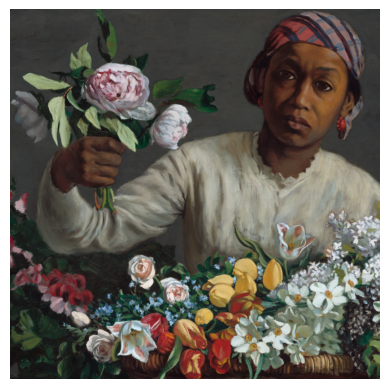

In [20]:
# Handle cases where the image dimensions are not divisible by the patch size
height, width, _ = img_array.shape
cropped_height = height - (height % patch_size)
cropped_width = width - (width % patch_size)

cropped_image = img_array[:cropped_height, :cropped_width, :]

# Initialize the reconstructed image
reconstructed_image = np.zeros_like(cropped_image, dtype=np.uint8)

patch_index = 0  # Index to keep track of the patches used from the database

for y in range(0, cropped_height, patch_size):
    for x in range(0, cropped_width, patch_size):
        if patch_index >= len(query_patches):
            break
        
        query_patch = query_patches[patch_index]

        best_similarity = float('inf')  # Initialize with a high value
        best_patch_index = None

        for i, patch in enumerate(query_patches):
            similarity = calculate_similarity(query_patch, patch, metric="mse")  # Use MSE as the similarity metric

            if similarity < best_similarity:
                best_similarity = similarity
                best_patch_index = i

        best_patch = query_patches[best_patch_index]

        # Place the best-fitting patch in the reconstructed image
        reconstructed_image[y:y+patch_size, x:x+patch_size, :] = best_patch

        patch_index += 1  # Move to the next query patch

        if patch_index >= len(query_patches):
            break

# Display the reconstructed image
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()